In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as stats

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
az.style.use('arviz-white')

# Hierarchical Model

For this model we may use NUTS as a "gold-standard"

In [3]:
data = pd.read_csv('radon.csv')

county_names = data.county.unique()
county_idx = data['county_code'].values.astype(np.int32)
n_counties = len(data.county.unique())

In [4]:
with pm.Model() as hierarchical_model_non_centered:
    mu_a = pm.Normal('mu_a', mu=0., sigma=5)
#     sigma_a = pm.HalfNormal('sigma_a', 5)
    sigma_a = pm.Exponential('sigma_a', lam=10)#Try a distribution with heavier tails
    mu_b = pm.Normal('mu_b', mu=0., sigma=5)
#     sigma_b = pm.HalfNormal('sigma_b', 5)
    sigma_b = pm.Exponential('sigma_b', lam=10)#Try a distribution with heavier tails
     
    a_offset = pm.Normal('a_offset', mu=0, sigma=2, shape=n_counties)
    a = pm.Deterministic("a", mu_a + a_offset * sigma_a)
    b_offset = pm.Normal('b_offset', mu=0, sigma=2, shape=n_counties)
    b = pm.Deterministic("b", mu_b + b_offset * sigma_b)
 
    eps = pm.HalfNormal('eps', 5)
    
    radon_est = a[county_idx] + b[county_idx] * data.floor.values
    
    radon_like = pm.Normal('radon_like', mu=radon_est, sigma=eps, observed=data.log_radon)
    
    #Try different samplers
    idata_nuts = pm.sample(2000,
                           chains=4,
                           idata_kwargs={"log_likelihood": True})
    idata_smc_M = pm.sample_smc(5000, kernel=pm.smc.kernels.MH,
                                chains=4,
                                idata_kwargs={"log_likelihood": True})
    idata_smc_I = pm.sample_smc(5000, kernel=pm.smc.kernels.IMH,
                                chains=4,
                                idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [mu_a, sigma_a, mu_b, sigma_b, a_offset, b_offset, eps]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 31 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
Initializing SMC sampler...
Sampling 4 chains in 3 jobs


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing SMC sampler...
Sampling 4 chains in 3 jobs


In [5]:
idata_smc_M.sample_stats._t_sampling, idata_smc_I.sample_stats._t_sampling

(90.23341608047485, 97.40364193916321)

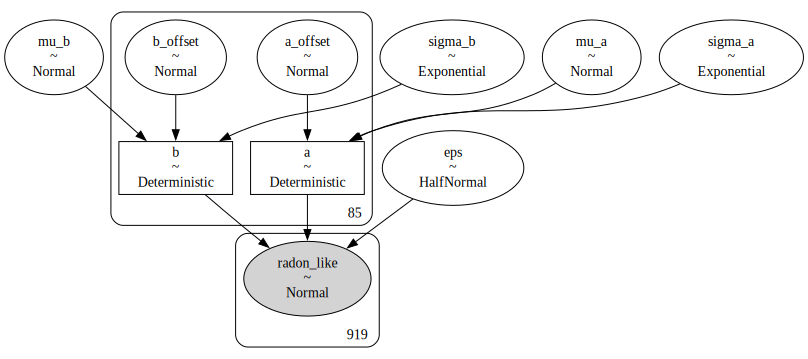

In [6]:
pm.model_to_graphviz(hierarchical_model_non_centered)

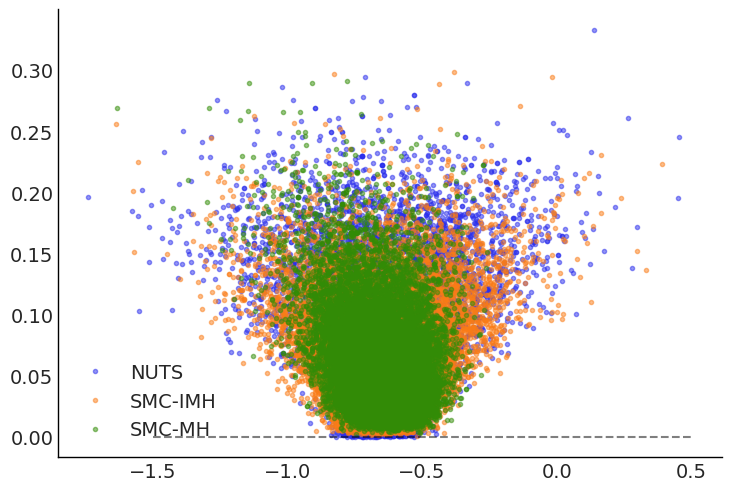

In [7]:
nuts_posterior = idata_nuts.posterior.stack(samples=("chain", "draw"))
smc_I_posterior = idata_smc_I.posterior.stack(samples=("chain", "draw"))
smc_M_posterior = idata_smc_M.posterior.stack(samples=("chain", "draw"))

plt.plot(nuts_posterior["b"].isel(b_dim_0=75),
         nuts_posterior["sigma_b"], 
         '.C0', alpha=0.5,
         label="NUTS")
plt.plot(smc_I_posterior["b"].isel(b_dim_0=75),
         smc_I_posterior["sigma_b"],
         '.C1', alpha=0.5,
         label="SMC-IMH")
plt.plot(smc_M_posterior["b"].isel(b_dim_0=75), 
         smc_M_posterior["sigma_b"],
         '.C2', alpha=0.5,
         label="SMC-MH")
plt.hlines(0, -1.5, 0.5, colors='black',
           linestyles='dashed', alpha=0.5)
plt.legend();

When the group variance is small, this implies that the individual random slopes are themselves close to the group mean. This results in a funnel-shaped relationship between the samples of group variance and any of the slopes (particularly those with a smaller sample size).  
In itself, this is not a problem, since this is the behavior we expect. However, if the sampler is tuned for the wider (unconstrained) part of the parameter space, it has trouble in the areas of higher curvature. The consequence of this is that the neighborhood close to the lower bound of
is sampled poorly; indeed, in our chain it is not sampled at all below 0.1 (SMC-MH). The result of this will be biased inference.  
[source](https://www.pymc.io/projects/examples/en/latest/case_studies/multilevel_modeling.html#example-radon-contamination-gelman2006data)

/home/pablo/anaconda3/envs/smc/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


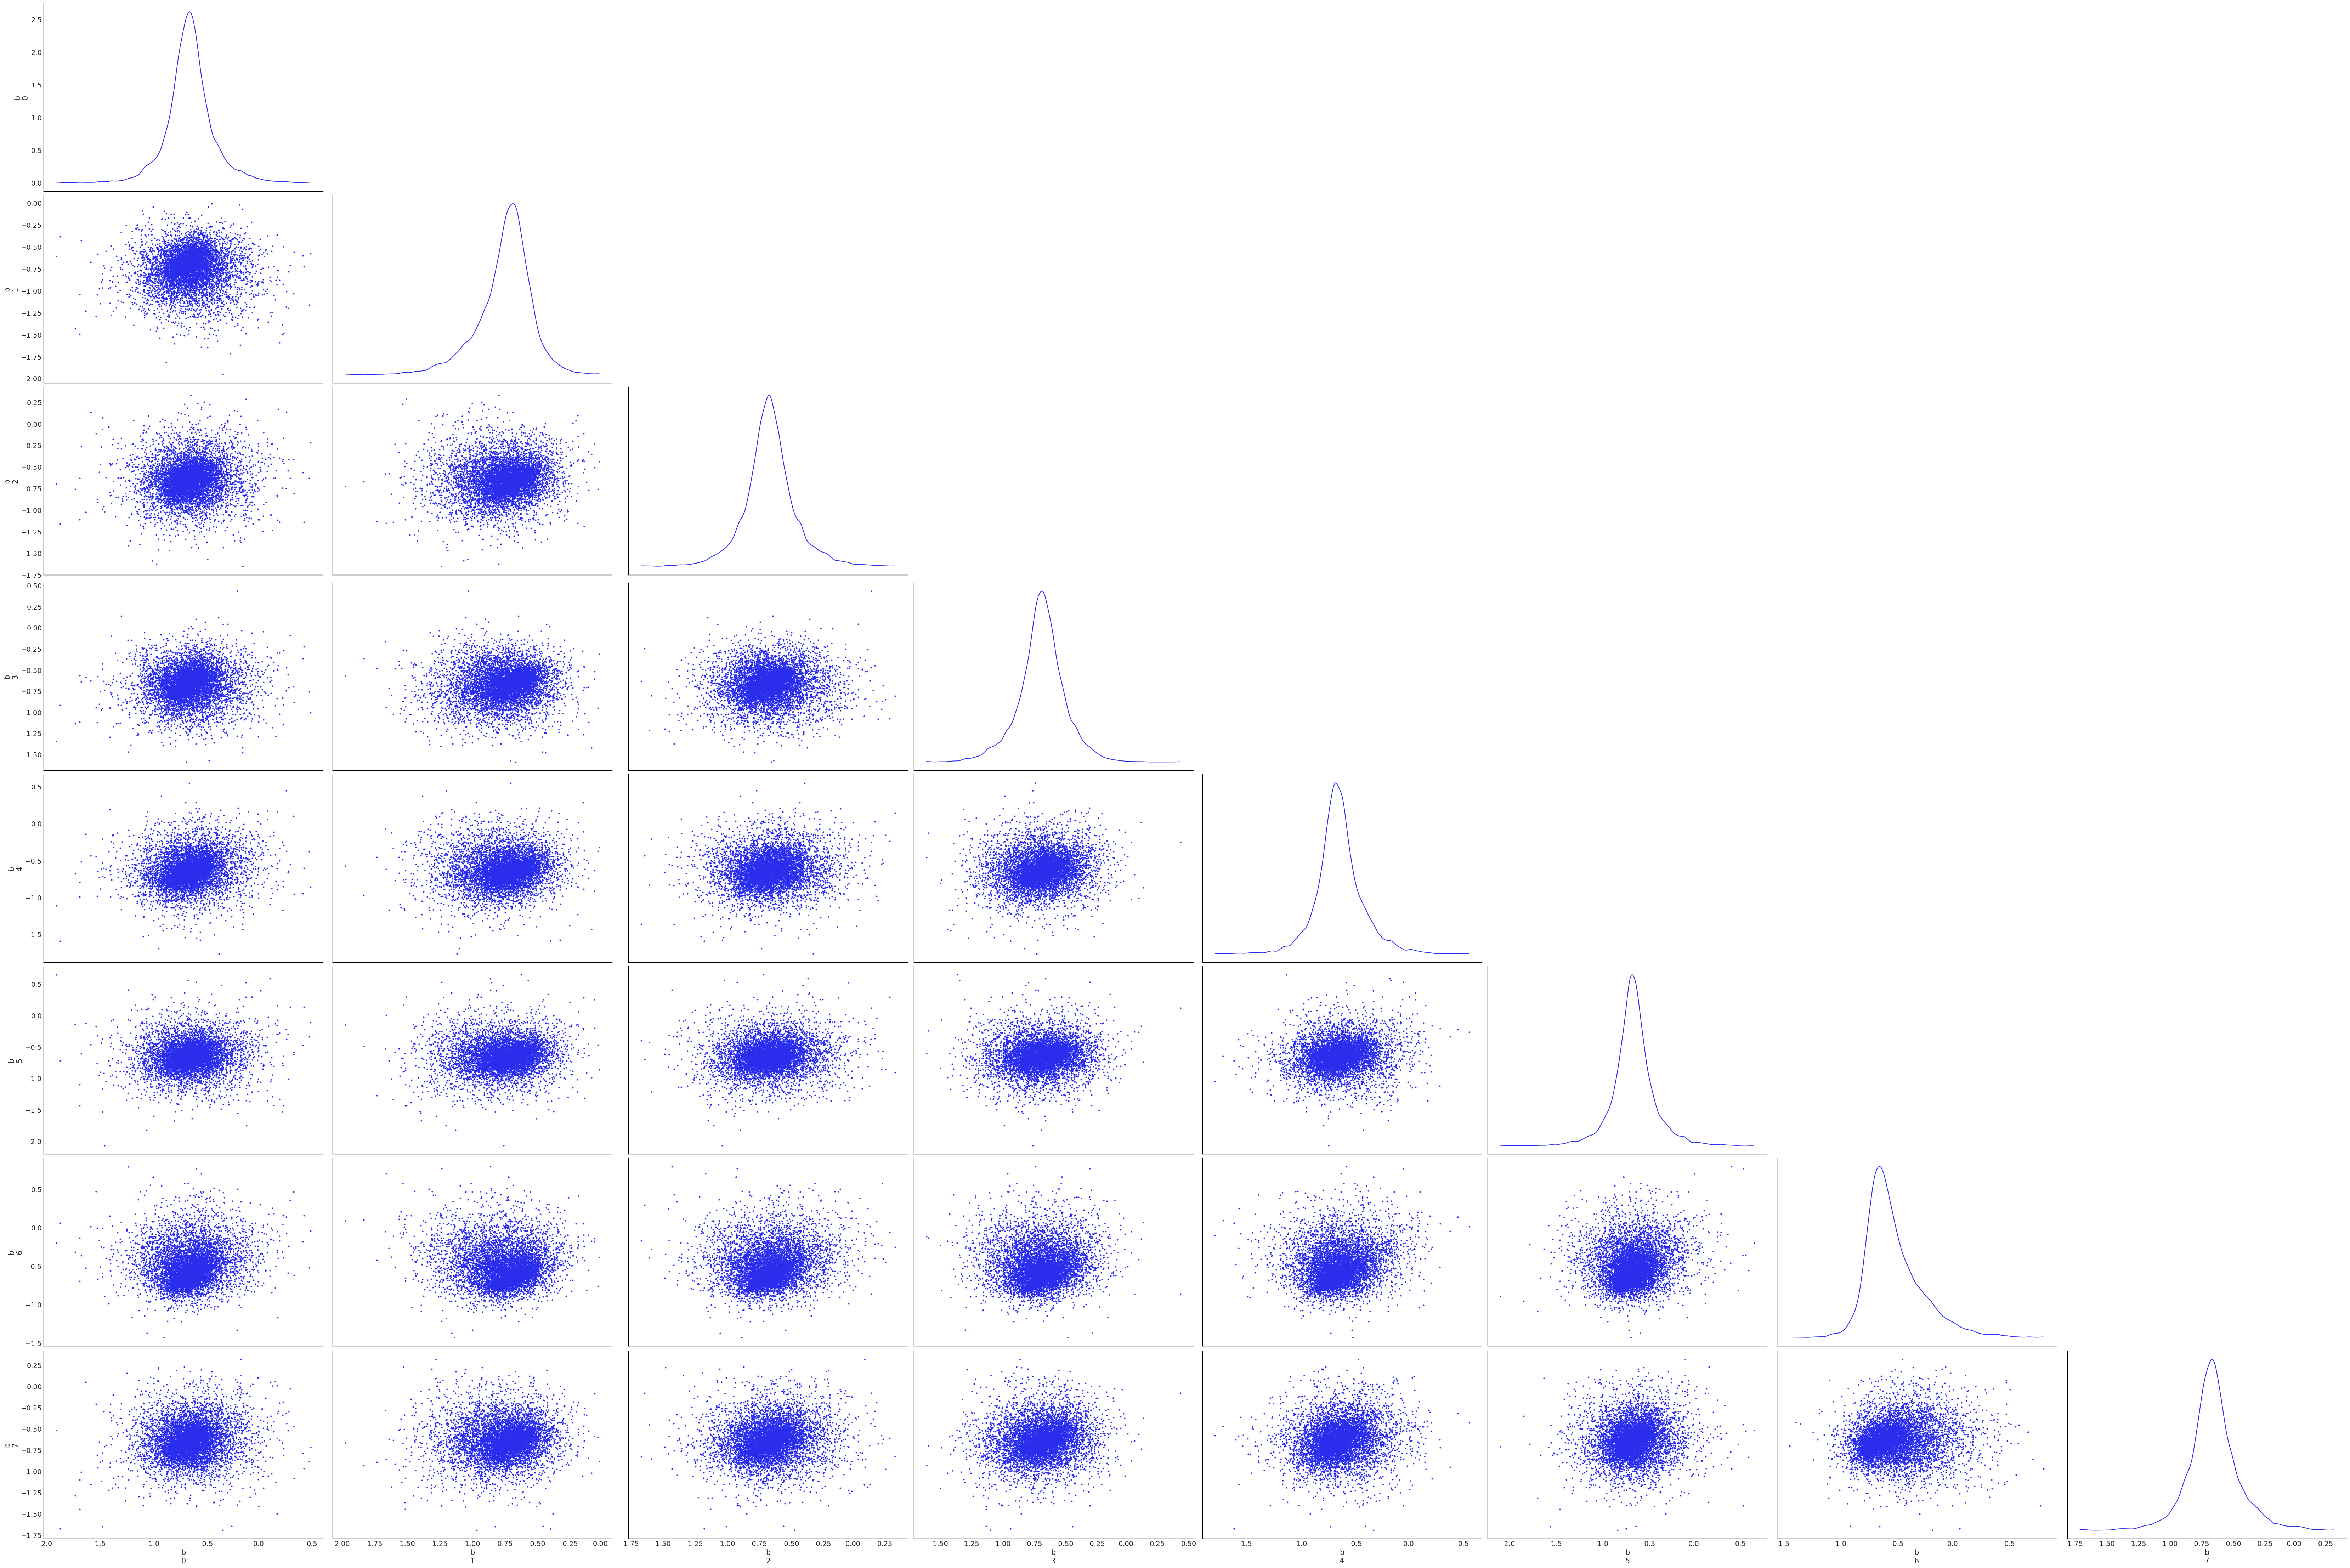

In [8]:
ax = az.plot_pair(
    idata_nuts,
    var_names=["b", "sigma_b"],
    marginals=True,
#     coords=dict(county="AITKIN"),
#     marginal_kwargs={"kind": "hist"},
)

In [9]:
model_compare = az.compare(
    {
        "NUTS": idata_nuts,
        "MH": idata_smc_M,
        "IMH": idata_smc_I,
    }
)

/home/pablo/anaconda3/envs/smc/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/pablo/anaconda3/envs/smc/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/pablo/anaconda3/envs/smc/lib/python3.9/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [10]:
model_compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
NUTS,0,-1038.395107,59.462574,0.000000,0.993784,28.534348,0.000000,True,log
IMH,1,-1040.318265,50.410713,1.923158,0.000000,27.741866,1.506539,False,log
MH,2,-1057.555282,38.233965,19.160175,0.006216,26.355600,5.312113,False,log


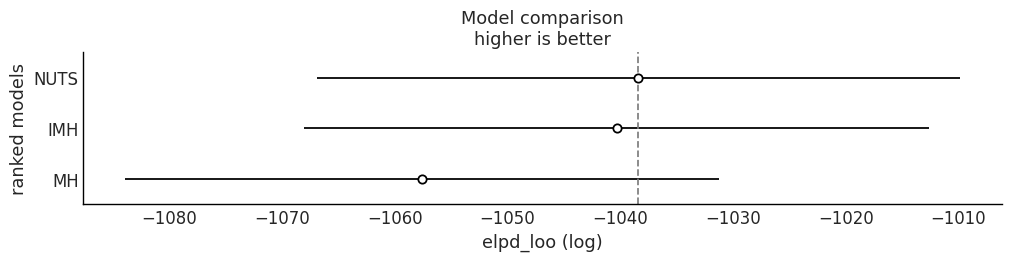

In [11]:
az.plot_compare(
    model_compare,
    plot_ic_diff=False,
    insample_dev=False,
    figsize=(10, 2.5),
    legend=False,
);

In [12]:
az.rhat(idata_nuts, var_names=["sigma_b", "b"])

<xarray.Dataset>
Dimensions:  (b_dim_0: 85)
Coordinates:
  * b_dim_0  (b_dim_0) int64 0 1 2 3 4 5 6 7 8 9 ... 76 77 78 79 80 81 82 83 84
Data variables:
    sigma_b  float64 1.003
    b        (b_dim_0) float64 1.001 1.001 1.002 1.0 ... 1.0 1.001 1.001 1.001

In [13]:
az.rhat(idata_smc_M, var_names=["sigma_b", "b"])

<xarray.Dataset>
Dimensions:  (b_dim_0: 85)
Coordinates:
  * b_dim_0  (b_dim_0) int64 0 1 2 3 4 5 6 7 8 9 ... 76 77 78 79 80 81 82 83 84
Data variables:
    sigma_b  float64 1.162
    b        (b_dim_0) float64 1.034 1.051 1.031 1.053 ... 1.056 1.15 1.126

In [14]:
az.rhat(idata_smc_I, var_names=["sigma_b", "b"])

<xarray.Dataset>
Dimensions:  (b_dim_0: 85)
Coordinates:
  * b_dim_0  (b_dim_0) int64 0 1 2 3 4 5 6 7 8 9 ... 76 77 78 79 80 81 82 83 84
Data variables:
    sigma_b  float64 1.003
    b        (b_dim_0) float64 1.001 1.001 1.0 1.002 ... 1.001 1.004 1.001 1.003